In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os, shutil
from tqdm import tqdm
import pickle
import math

from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet152
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten,Input
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend, layers, models,utils
from keras.utils import multi_gpu_model
from keras_efficientnets.efficientnet import EfficientNetB3

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10495847339474688588
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7061687501
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15363301327398722271
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


# 预处理

In [35]:
with open('ex_files.txt', 'rb') as ef:
    ex_files = pickle.load(ef)
len(ex_files['resnet50'])

130

In [36]:
data_dir = './{}/'
files = {x: os.listdir(data_dir.format(x)) for x in ['train', 'test']}
clean_data = [i for i in files['train'] if i not in ex_files['resnet50']]
len(clean_data)

24870

In [37]:
clean_labels = [x.split('.')[0] for x in clean_data]
{i: clean_labels.count(i) for i in set(clean_labels)}

{'cat': 12389, 'dog': 12481}

In [38]:
data_dir = './train/'
nb_class = 2
with open('data_set.txt', 'rb') as ds:
    data_set = pickle.load(ds)

In [39]:
file_df = pd.DataFrame({'file_names': clean_data, 'labels': [x.split('.')[0] for x in clean_data]})
file_train, file_valid, label_train, label_valid = train_test_split(file_df['file_names'], file_df['labels'],
                                                                    test_size = 0.2, random_state = 0)
file_valid = file_valid.tolist()
file_train = file_train.tolist()
print(len(file_train), len(file_valid), len(label_train), len(label_valid))

19896 4974 19896 4974


In [40]:
data_set = {'file_train': file_train, 'label_train': label_train, 'file_valid': file_valid, 'label_valid': label_valid}
with open('data_set.txt', 'wb') as ds:
    pickle.dump(data_set, ds)

检查两个数据集有没有重叠

In [41]:
# print(any([data['valid']['cat'][x] in data['train']['cat'] for x in range(len(data['valid']['cat']))]))
# print(any([data['valid']['dog'][x] in data['train']['dog'] for x in range(len(data['valid']['dog']))]))

## 图像变换

In [42]:
dataf = {x: pd.DataFrame({'X': data_set['file_{}'.format(x)],
                          'Y'.format(x): data_set['label_{}'.format(x)]}) for x in ['train', 'valid']}
dataf['train'].head()

,X,Y
24490,dog.9657.jpg,dog
16089,dog.2088.jpg,dog
19874,dog.5499.jpg,dog
11343,cat.9045.jpg,cat
6803,cat.4923.jpg,cat


```python
datagen = {'train': image.ImageDataGenerator(
   preprocessing_function=preprocess_input,
#     rotation_range=20
#     ,width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
    horizontal_flip=True
#     ,vertical_flip=True
),
           'valid':image.ImageDataGenerator(
   preprocessing_function=preprocess_input
)
          }
```

或者简单写法便于一个个增删：

In [43]:
datagen = {x: image.ImageDataGenerator(preprocessing_function=preprocess_input) for x in dataf.keys()}
datagen['train'].horizontal_flip = True
datagen['train'].rotation_range = 30
# datagen['train'].zoom_range = [0.2, 0.2]
# datagen['train'].vertical_flip = True
# datagen['train'].zoom_range

In [44]:
im_width, im_height = 224, 224
batch_size = 128

generator = {x: datagen[x].flow_from_dataframe(
    dataf[x], x_col = 'X', y_col = 'Y',directory = data_dir.format('train'),
    target_size=(im_width, im_height),
    batch_size=batch_size,
    seed = 123,
    class_mode = 'binary'
) for x in datagen.keys()}

generator['valid'].shuffle = False

Found 19896 validated image filenames belonging to 2 classes.
Found 4974 validated image filenames belonging to 2 classes.


## 建立模型

选择三个模型：

In [45]:
model_dict = {'ResNet50': ResNet50, 'ResNet152': ResNet152, 'EfficientNetB3': EfficientNetB3}

model_name = 'ResNet152'

载入模型并排除顶部的全连接层。

In [46]:
# tf.reset_default_graph() 
if model_name == 'ResNet152':
    model_base = ResNet152(weights = 'imagenet', include_top = False, input_shape = (im_width, im_height, 3),
                           backend = backend, layers = layers, models = models, utils = utils)
else:
    model_base = model_dict[model_name](weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3))

添加自己的层：

In [47]:
model = Sequential()
model.add(model_base)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.75))
# model.add(Dense(500, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid'))

或者这种写法：
```python
x = model_base.output
# x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5,)(x)
# x = Dense(500, activation='relu')(x)
# x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=model_base.input, outputs=output)
```

查看冻结层前后的可训练层数：

In [48]:
print('Number of trainable weights befor freezing the model_base:', len(model.trainable_weights))
# for layer in model.layers[:173]:
#     layer.trainable = False
model_base.trainable = False
print('Number of trainable weights after freezing the model_base:', len(model.trainable_weights))

Number of trainable weights befor freezing the model_base: 622
Number of trainable weights after freezing the model_base: 2


In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 58,372,993
Trainable params: 2,049
Non-trainable params: 58,370,944
_________________________________________________________________


编译模型：

In [50]:
lr = 0.00005
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(lr=lr), metrics=["accuracy"])

## 训练模型

In [51]:
epochs = 30
history = model.fit_generator(generator['train'],
                              steps_per_epoch=math.ceil(generator['train'].samples / batch_size),
                              epochs=epochs,
                              validation_data=generator['valid'],
                              validation_steps=math.ceil(generator['valid'].samples / batch_size),
                              callbacks=[early_stopping],
                              verbose = 2)

Epoch 1/30
 - 201s - loss: 0.9014 - acc: 0.5695 - val_loss: 0.4468 - val_acc: 0.8285
Epoch 2/30
 - 187s - loss: 0.6236 - acc: 0.7085 - val_loss: 0.2535 - val_acc: 0.9487
Epoch 3/30
 - 187s - loss: 0.4760 - acc: 0.7863 - val_loss: 0.1671 - val_acc: 0.9684
Epoch 4/30
 - 187s - loss: 0.3808 - acc: 0.8380 - val_loss: 0.1249 - val_acc: 0.9733
Epoch 5/30
 - 187s - loss: 0.3168 - acc: 0.8705 - val_loss: 0.0991 - val_acc: 0.9777
Epoch 6/30
 - 187s - loss: 0.2759 - acc: 0.8920 - val_loss: 0.0844 - val_acc: 0.9797
Epoch 7/30
 - 187s - loss: 0.2480 - acc: 0.9044 - val_loss: 0.0741 - val_acc: 0.9817
Epoch 8/30
 - 187s - loss: 0.2218 - acc: 0.9135 - val_loss: 0.0696 - val_acc: 0.9811
Epoch 9/30
 - 187s - loss: 0.2066 - acc: 0.9223 - val_loss: 0.0655 - val_acc: 0.9807
Epoch 10/30
 - 187s - loss: 0.1902 - acc: 0.9295 - val_loss: 0.0592 - val_acc: 0.9821
Epoch 11/30
 - 187s - loss: 0.1824 - acc: 0.9290 - val_loss: 0.0575 - val_acc: 0.9817
Epoch 12/30
 - 187s - loss: 0.1735 - acc: 0.9326 - val_loss: 0.

保存模型checkpoint：

In [52]:
model.save('model_binary.h5')

## 重新载入模型

In [53]:
# model = load_model('model_binary.h5')

## 可视化

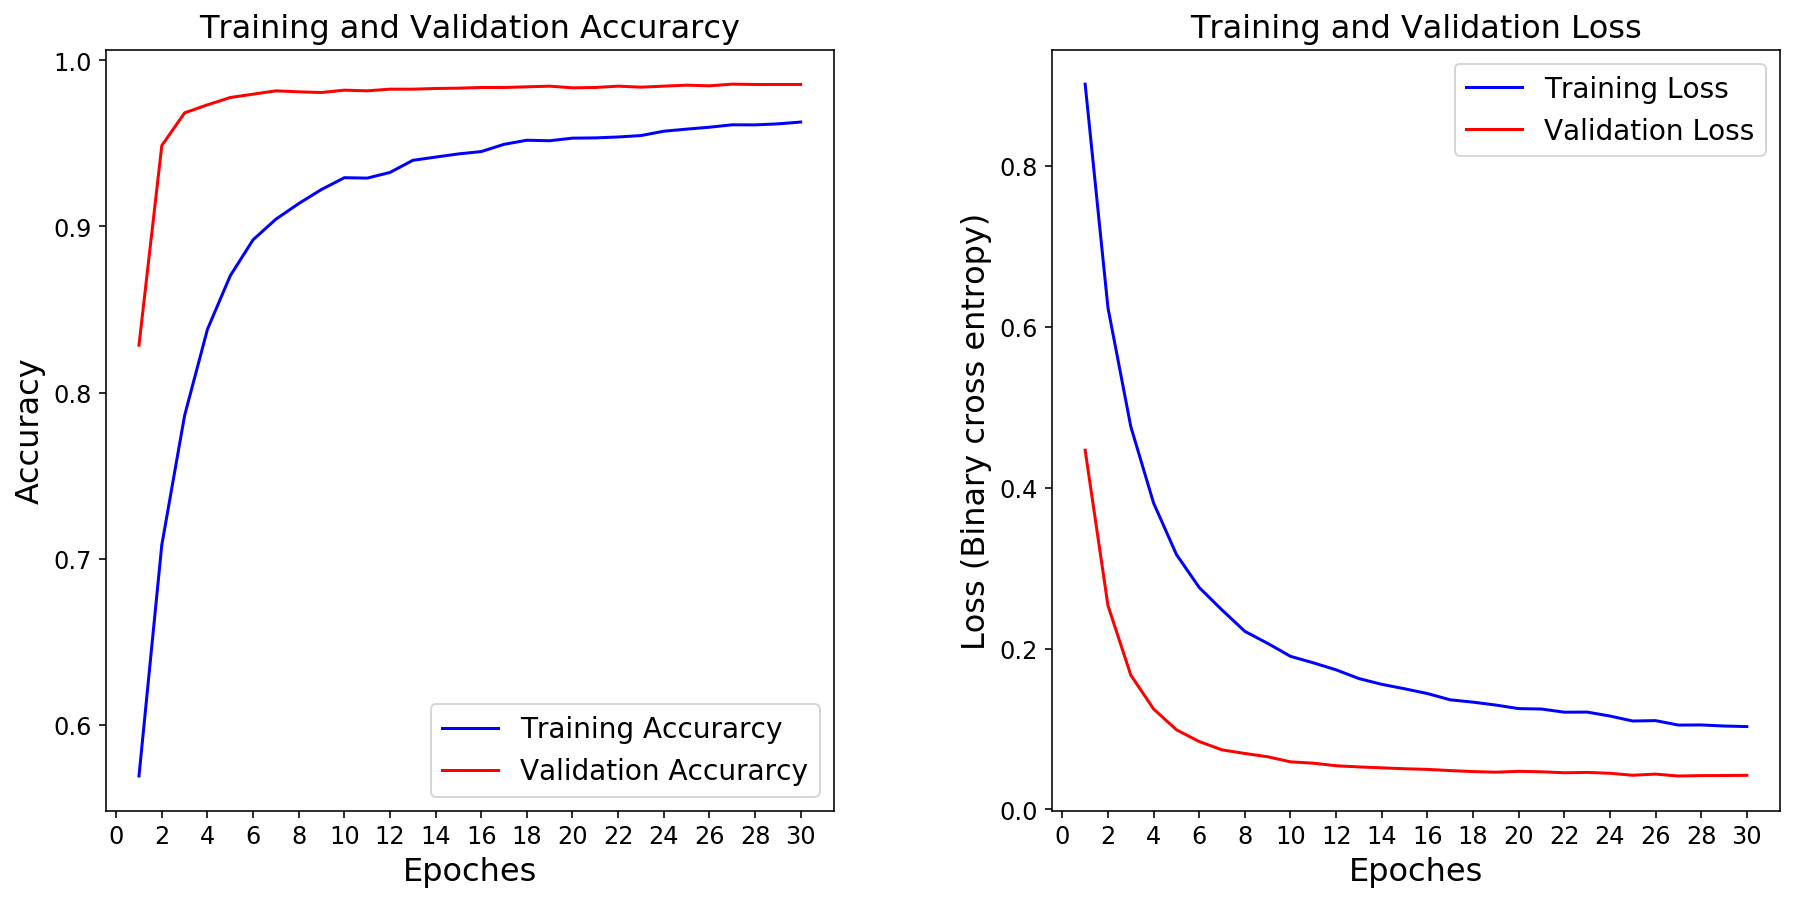

In [54]:
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

x_axis = range(1, len(acc)+1)

#Train and validation accuracy

plt.figure(figsize = [15, 7])
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
plt.plot(x_axis, acc, 'blue', label='Training Accurarcy')
plt.plot(x_axis, val_acc, 'red', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy', fontsize = 16)
plt.xlabel('Epoches', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.legend(fontsize = 14)
plt.xticks(ticks=range(0, len(acc)+1, 2),fontsize = 12)
plt.yticks(fontsize = 12)


plt.subplot(1,2,2)
#Train and validation loss
plt.plot(x_axis, loss, 'blue', label='Training Loss')
plt.plot(x_axis, val_loss, 'red', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize = 16)
plt.xlabel('Epoches', fontsize = 16)
plt.ylabel('Loss (Binary cross entropy)', fontsize = 16)
plt.legend(fontsize = 14)
plt.xticks(ticks=range(0, len(acc)+1, 2), fontsize = 12)
plt.yticks(fontsize = 12)

# plt.suptitle('Pre-trained model: {}\nLearning rate: {}'.format(model_name, lr),
#             x = 0.1, y = 1, ha = 'left', fontsize = 14)
plt.savefig('{} loss and acc-lr {}.jpg'.format(model_name, lr), bbox_inches = 'tight')
plt.show()

# 预测

9.340972e-06


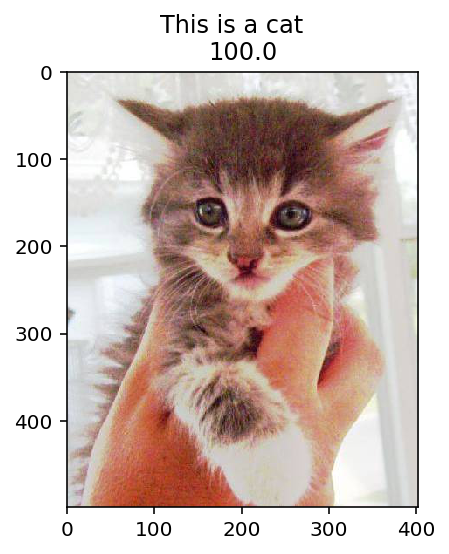

In [55]:
test_imgs = os.listdir(data_dir.format('test'))
img_path = data_dir.format('test') + test_imgs[3]
# img_path = './test04.jpg'
img = image.load_img(img_path, target_size=(im_width, im_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)[0][0]
print(preds)
img_show = mpimg.imread(img_path)
plt.imshow(img_show)
plt.suptitle('This is a {}'.format('dog' if preds > 0.5 else 'cat'))
plt.title('probability: {}%'.format(round(preds*100, 2)) if preds > 0.5 else round((1-preds)*100, 2));

全部预测，制作csv表

In [56]:
test_imgs = os.listdir('test/')
ids = []
label = []
for i in tqdm(test_imgs):
    img = image.load_img('test/' + i, target_size=(im_width, im_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    label.append(model.predict(x)[0][0])
    ids.append(int(i.split('.')[0]))

100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [05:33<00:00, 37.77it/s]


In [57]:
sub = pd.DataFrame({'id': ids, 'label': label}).sort_values('id',axis = 0, ascending = True)
sub.to_csv('submission.csv', index = False)

# 参考资料

+ https://zhuanlan.zhihu.com/p/26693647
+ https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8
+ https://www.kaggle.com/risingdeveloper/transfer-learning-in-keras-on-dogs-vs-cats